In [1]:
from pycocotools.coco import COCO
import numpy as np
from pycocotools.cocoeval import COCOeval
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from tqdm import tqdm

In [7]:
dataDir='/home/wsg/dataset/VisDrone_Dataset_COCO_Format/images/instances_UAVval'
dataType='val2017'
annFile='/home/wsg/dataset/VisDrone_Dataset_COCO_Format/annotations/instances_UAVval.json'
coco_gt=COCO(annFile)
catIds = coco_gt.getCatIds()
cats = coco_gt.loadCats(coco_gt.getCatIds())
imgIds = coco_gt.getImgIds()

annIds_gt = coco_gt.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
anns_gt = coco_gt.loadAnns(annIds_gt)

result_json = "/home/wsg/sod/coco_tools/results/reppoints_v2_visdrone_val_results.bbox.json"
coco_dt = coco_gt.loadRes(result_json)
annIds_dt = coco_dt.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
anns_dt = coco_dt.loadAnns(annIds_dt)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!


In [3]:
import json
with open("./small_img_list.json","r") as f:
    small_img_list = json.load(f)

In [4]:
per_img_ann_nums = {"img_id":[],"small_object_num":[]}
for img_id,ann in small_img_list.items():
    per_img_ann_nums["img_id"].append(img_id)
    per_img_ann_nums["small_object_num"].append(len(ann)) 
df = pd.DataFrame(per_img_ann_nums)
df.describe()  #gt中小目标的数量分布

,small_object_num
count,2160.000000
mean,5.311574
std,5.314705
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,32.000000


In [5]:
many_small_obj = df[df["small_object_num"]>20] #选择有20个以上小目标的图片
img_id_list = many_small_obj["img_id"].astype(int).to_list()
img_list = coco_gt.loadImgs(img_id_list)  #小目标图片信息

## 可视化函数

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def get_bbox(coco,imgIds,catIds):
    annIds = coco.getAnnIds(imgIds=imgIds, catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    boxes, labels, scores = [],[],[]
    # print(anns[0])
    for ann in anns:
        boxes.append(ann["bbox"])
        labels.append(ann["category_id"])
        scores.append(ann.get("score",1))
    return (boxes,labels,scores)

classes = [cat['name'] for cat in cats]
# classes = [line.rstrip('\n') for line in open('coco_classes.txt')]
coco_catid_map = {k:i for i,k in enumerate(coco_gt.getCatIds())} #coco catid 最大到90,但是只有80累

def display_objdetect_image(image_path, gt, pred, score_threshold=0.7,show_label=True,drew_list=["gt","pred"]):
    image = Image.open(image_path)
    _, ax = plt.subplots(1, figsize=(12,9))
    image = np.array(image)
    ax.imshow(image)


    # Showing boxes with score > 0.7
    if "gt" in drew_list:
        for box, label, score in zip(*gt):
            if score > score_threshold:
                # if label>len(classes):print("error!",label)
                # coco 数据集存在标签错误？？！ 竟然出现83的索引，似乎并不是标错了。
                rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='g', facecolor='none')
                # 为了清晰，不显示gt的类别和置信度
                # if show_label:
                #     ax.annotate(classes[coco_catid_map[label]] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='w', fontsize=12)
                ax.add_patch(rect)
    if "pred" in drew_list:
        for box, label, score in zip(*pred):
            if score > score_threshold:
                # if label>len(classes):print("error!",label)
                rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
                if show_label:
                    ax.annotate(classes[coco_catid_map[label]] + ':' + str(np.round(score, 2)), (box[0], box[1]), color='b', fontsize=12)
                ax.add_patch(rect)
    plt.show()

In [9]:
# img = img_list[0]
img = coco_gt.loadImgs([0])[0] #获取指定id的图片信息
img["file_name"]

'0000276_01201_d_0000513.jpg'

In [10]:
gt = get_bbox(coco_gt,img["id"],catIds)
pred = get_bbox(coco_dt,img["id"],catIds)


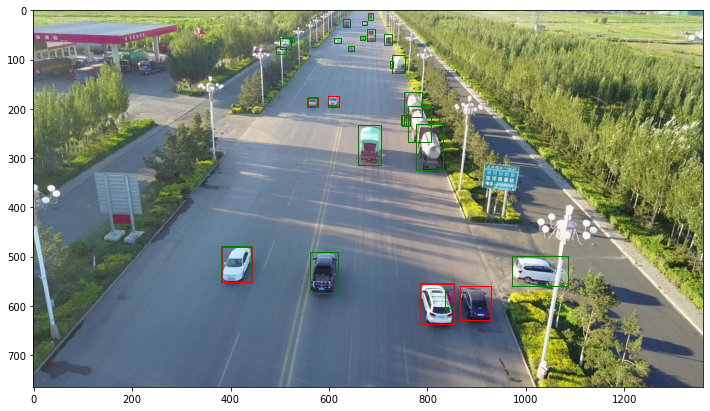

In [13]:
import os
img_path = os.path.join(dataDir,img["file_name"])
display_objdetect_image(img_path, gt, pred, score_threshold=0.8,show_label=False,drew_list=["gt","pred"])

## 分析pred目标尺寸和置信度的关系

In [10]:
area_score = {"area":[],"score":[]}
for ann in tqdm(anns_dt):
    bbox = ann["bbox"]
    score = ann["score"]
    area = bbox[2] * bbox[3]
    area_score["area"].append(area)
    area_score["score"].append(score)
area_score = pd.DataFrame(area_score)

100%|██████████| 495200/495200 [00:00<00:00, 1180707.60it/s]


In [11]:
area_score.describe()

,area,score
count,495200.000000,495200.000000
mean,34824.095689,0.118115
std,58783.548515,0.134545
min,0.000000,0.000000
25%,1029.718258,0.057942
50%,6110.753102,0.081742
75%,41283.759729,0.133065
max,417056.628809,0.995840


In [88]:
target_df = area_score[area_score["score"]>0.5]
print(target_df.describe())
target_df.corr()

                area         score
count   14706.000000  14706.000000
mean    34810.375197      0.715507
std     50115.922128      0.135289
min       184.450373      0.500020
25%      4102.123688      0.595798
50%     13456.566265      0.708124
75%     43335.347927      0.834260
max    370040.965554      0.995840


,area,score
area,1.000000,0.212301
score,0.212301,1.000000


array([[<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'score'}>]], dtype=object)

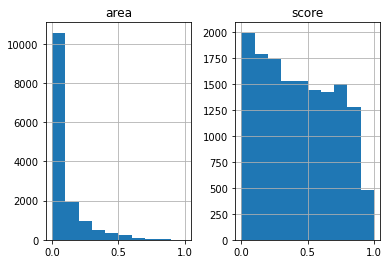

In [20]:
target_norm_df = ((target_df - target_df.min())/(target_df.max()-target_df.min()))
target_norm_df.hist()

In [89]:
cocoEval = COCOeval(coco_gt,coco_dt,"bbox")
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=65.49s).
Accumulating evaluation results...
DONE (t=14.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.494
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.282
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.432
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

In [2]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")
demo.launch()

AttributeError: module 'gradio' has no attribute 'Interface'